In [1]:
%load_ext rpy2.ipython
%matplotlib inline

from neuralprophet import Prophet
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import logging
import warnings

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df = df.loc[:180,]  # Limit to first six months
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=60)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.685% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 384


  0%|          | 0/111 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.44E-02, min: 1.65E-01


  0%|          | 0/111 [00:00<?, ?it/s]

{'self': <neuralprophet.wrapper.Prophet object at 0x104472580>, 'growth': 'linear', 'changepoints': None, 'n_changepoints': 25, 'changepoints_range': 0.8, 'trend_reg': 0, 'trend_reg_threshold': False, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'seasonality_reg': 0, 'n_forecasts': 1, 'n_lags': 0, 'num_hidden_layers': 0, 'd_hidden': None, 'ar_reg': None, 'learning_rate': None, 'epochs': None, 'batch_size': None, 'loss_func': 'Huber', 'optimizer': 'AdamW', 'newer_samples_weight': 2, 'newer_samples_start': 0.0, 'uncertainty_method': 'auto', 'prediction_interval': 0.8, 'quantiles': None, 'impute_missing': True, 'impute_linear': 10, 'impute_rolling': 10, 'drop_missing': False, 'collect_metrics': True, 'normalize': 'auto', 'global_normalization': False, 'global_time_normalization': True, 'unknown_data_normalization': False}


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.44E-02, min: 2.00E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.46E-02
Epoch[384/384]: 100%|██████████| 384/384 [00:08<00:00, 46.63it/s, SmoothL1Loss=0.0108, MAE=0.254, RMSE=0.365, Loss=0.0097, RegLoss=0] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.685% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


By default Prophet will return uncertainty intervals for the forecast `yhat`. There are several important assumptions behind these uncertainty intervals.

There are three sources of uncertainty in the forecast: uncertainty in the trend, uncertainty in the seasonality estimates, and additional observation noise.

### Uncertainty in the trend
The biggest source of uncertainty in the forecast is the potential for future trend changes. The time series we have seen already in this documentation show clear trend changes in the history. Prophet is able to detect and fit these, but what trend changes should we expect moving forward? It's impossible to know for sure, so we do the most reasonable thing we can, and we assume that the *future will see similar trend changes as the history*. In particular, we assume that the average frequency and magnitude of trend changes in the future will be the same as that which we observe in the history. We project these trend changes forward and by computing their distribution we obtain uncertainty intervals.

One property of this way of measuring uncertainty is that allowing higher flexibility in the rate, by increasing `changepoint_prior_scale`, will increase the forecast uncertainty. This is because if we model more rate changes in the history then we will expect more in the future, and makes the uncertainty intervals a useful indicator of overfitting.

The width of the uncertainty intervals (by default 80%) can be set using the parameter `interval_width`:

In [4]:
m = Prophet(interval_width=0.95)
m.fit(df)
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.685% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 384


  0%|          | 0/111 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.42E-02, min: 1.37E-01


  0%|          | 0/111 [00:00<?, ?it/s]

{'self': <neuralprophet.wrapper.Prophet object at 0x16d250250>, 'growth': 'linear', 'changepoints': None, 'n_changepoints': 25, 'changepoints_range': 0.8, 'trend_reg': 0, 'trend_reg_threshold': False, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'seasonality_reg': 0, 'n_forecasts': 1, 'n_lags': 0, 'num_hidden_layers': 0, 'd_hidden': None, 'ar_reg': None, 'learning_rate': None, 'epochs': None, 'batch_size': None, 'loss_func': 'Huber', 'optimizer': 'AdamW', 'newer_samples_weight': 2, 'newer_samples_start': 0.0, 'uncertainty_method': 'auto', 'prediction_interval': 0.95, 'quantiles': None, 'impute_missing': True, 'impute_linear': 10, 'impute_rolling': 10, 'drop_missing': False, 'collect_metrics': True, 'normalize': 'auto', 'global_normalization': False, 'global_time_normalization': True, 'unknown_data_normalization': False}


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.03E-02, min: 7.78E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.12E-02
Epoch[384/384]: 100%|██████████| 384/384 [00:05<00:00, 67.60it/s, SmoothL1Loss=0.0107, MAE=0.253, RMSE=0.376, Loss=0.00776, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.51% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.51% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Again, these intervals assume that the future will see the same frequency and magnitude of rate changes as the past. This assumption is probably not true, so you should not expect to get accurate coverage on these uncertainty intervals.

### Uncertainty in seasonality
By default Prophet will only return uncertainty in the trend and observation noise. To get uncertainty in seasonality, you must do full Bayesian sampling. This is done using the parameter `mcmc.samples` (which defaults to 0). We do this here for the first six months of the Peyton Manning data from the Quickstart:

In [6]:
m = Prophet(mcmc_samples=300)
m.fit(df)
forecast = m.predict(future)

INFO - (NP.forecaster.__init__) - Providing the number of samples for Bayesian inference or Uncertainty estimation is not required in NeuralProphet.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.685% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 384


  0%|          | 0/111 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.39E-02, min: 2.91E-01


  0%|          | 0/111 [00:00<?, ?it/s]

{'self': <neuralprophet.wrapper.Prophet object at 0x16d252b20>, 'growth': 'linear', 'changepoints': None, 'n_changepoints': 25, 'changepoints_range': 0.8, 'trend_reg': 0, 'trend_reg_threshold': False, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'seasonality_reg': 0, 'n_forecasts': 1, 'n_lags': 0, 'num_hidden_layers': 0, 'd_hidden': None, 'ar_reg': None, 'learning_rate': None, 'epochs': None, 'batch_size': None, 'loss_func': 'Huber', 'optimizer': 'AdamW', 'newer_samples_weight': 2, 'newer_samples_start': 0.0, 'uncertainty_method': 'auto', 'prediction_interval': 0.8, 'quantiles': None, 'impute_missing': True, 'impute_linear': 10, 'impute_rolling': 10, 'drop_missing': False, 'collect_metrics': True, 'normalize': 'auto', 'global_normalization': False, 'global_time_normalization': True, 'unknown_data_normalization': False}


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.39E-02, min: 2.41E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.59E-02
Epoch[384/384]: 100%|██████████| 384/384 [00:07<00:00, 52.85it/s, SmoothL1Loss=0.00914, MAE=0.233, RMSE=0.344, Loss=0.00821, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.51% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.51% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


This replaces the typical MAP estimation with MCMC sampling, and can take much longer depending on how many observations there are - expect several minutes instead of several seconds. If you do full sampling, then you will see the uncertainty in seasonal components when you plot them:

WARNING - (NP.forecaster.plot_components) - The attributes `uncertainty`, `plot_cap`, `weekly_start` and `yearly_start` are not supported by NeuralProphet


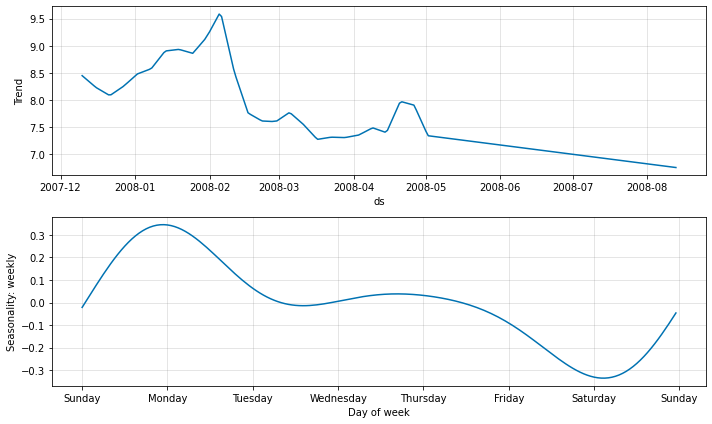

In [7]:
fig = m.plot_components(forecast)

You can access the raw posterior predictive samples in Python using the method `m.predictive_samples(future)`, or in R using the function `predictive_samples(m, future)`.